In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, concatenate, Conv2DTranspose, Conv2D, MaxPooling2D, Dropout
from keras import regularizers
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import imageio
import cv2




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
working_directory = '/content/drive/MyDrive/DLproject'
original_img_dic = f'{working_directory}/original_images/'
# masked_img_dic = f'{working_directory}/RGB_color_image_masks/RGB_color_image_masks/'
masked_img_dic = f'{working_directory}/label_images_semantic/'

In [ ]:
# final_h,final_w = 96,128
# final_h,final_w = 512,512
final_h,final_w = 384,512
org_image_list = os.listdir(original_img_dic)
masked_image_list = os.listdir(masked_img_dic)
org_image_list = sorted([original_img_dic+i for i in org_image_list])
masked_image_list = sorted([masked_img_dic+i for i in masked_image_list])

train_org_image_list = org_image_list[:350]
train_masked_image_list = masked_image_list[:350]

test_org_image_list = org_image_list[350:400]
test_masked_image_list = masked_image_list[350:400]
# for i in range(len(train_org_image_list)):

  #  print(train_org_image_list[i],train_masked_image_list[i])
# x = np.random.randint((0,400))

# n = 222
# org_image = img.imread(train_org_image_list[n])
# print(org_image.shape)
# masked_image = img.imread(train_masked_image_list[n])
# print(masked_image.shape)

# fig ,arr  = plt.subplots(1,2,figsize=(15,10))
# arr[0].imshow(org_image)
# arr[0].set_title('Original Image')
# arr[1].imshow(masked_image)
# arr[1].set_title('Mask')
# plt.show()

# def resize(org_image,masked_image) :
#     org_image = tf.image.resize(org_image,(512,512),method='nearest')
#     masked_image = tf.image.resize(masked_image,(512,512),method='nearest')
#     return org_image , masked_image

# i,j = resize(org_image,masked_image)

# print(i.shape)
# # masked_image = img.imread(train_masked_image_list[n])
# print(j.shape)

# fig ,arr  = plt.subplots(1,2,figsize=(15,10))
# arr[0].imshow(i)
# arr[0].set_title('Original Image after resize')
# arr[1].imshow(j)
# arr[1].set_title('Masked image after resize')
# plt.show()

In [ ]:
def convolution_layer(inputs = None,filters = 32,dropout = 0,max_pooling = True):
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv
    return next_layer, skip_connection


def upsampling(expansive_input,contractive_input,filters =32,dropout = 0):
    up = Conv2DTranspose(filters,kernel_size = 3,strides=(2,2),padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    conv = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    return conv



In [ ]:
def Unet(input_size = (final_h,final_w,3),filters = 32,classes = 23):
    inputs = Input(input_size)

    #encoding block
    c_1 = convolution_layer(inputs,filters,dropout=0.1)
    c_2 = convolution_layer(c_1[0],2*filters,dropout=0.2)
    c_3 = convolution_layer(c_2[0],4*filters,dropout=0.4)
    c_4 = convolution_layer(c_3[0],8*filters,dropout=0.4)
    c_5 = convolution_layer(c_4[0],16*filters,dropout=0.4)
    c_6 = convolution_layer(c_5[0],32*filters,dropout=0.4,max_pooling=None)

    u_6 = upsampling(c_6[0],c_5[1],16*filters,dropout = 0.45)
    u_7 = upsampling(u_6,c_4[1],8*filters,dropout = 0.45)
    u_8 = upsampling(u_7,c_3[1],4*filters,dropout = 0.4)
    u_9 = upsampling(u_8,c_2[1],2*filters,dropout = 0.2)
    u_10 = upsampling(u_9,c_1[1],filters,dropout = 0.1)

    conv10 = Conv2D(filters,kernel_size = 3,activation='relu',padding='same',kernel_initializer='he_normal')(u_10)

    conv11 = Conv2D(classes, kernel_size=1,padding='same', activation='softmax')(conv10)
    # conv11 = Conv2D(classes, kernel_size=1, padding='same')(conv10)

    model = Model(inputs=inputs, outputs=conv11)
    return model

Unet_model = Unet((final_h,final_w,3))
Unet_model.summary()
# Unet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
Unet_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 384, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 384, 512, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
train_org_images = tf.constant(train_org_image_list)
train_masked_images = tf.constant(train_masked_image_list)
train_dataset = tf.data.Dataset.from_tensor_slices((train_org_images,train_masked_images))
# for image,mask in train_dataset.take(1) :
#     print(image)
#     print(mask)
test_org_images = tf.constant(test_org_image_list)
test_masked_images = tf.constant(test_masked_image_list)
test_dataset = tf.data.Dataset.from_tensor_slices((test_org_images,test_masked_images))
# for image,mask in test_dataset.take(1) :
#     print(image)
#     print(mask)
print(train_org_images[0],train_masked_images[0])


tf.Tensor(b'/content/drive/MyDrive/DLproject/original_images/000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/DLproject/label_images_semantic/000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path,mask_path):
    org_image = tf.io.read_file(image_path)
    org_image = tf.image.decode_png(org_image,channels=3)
    org_image = tf.image.convert_image_dtype(org_image,tf.float32)

    masked_image = tf.io.read_file(mask_path)
    masked_image = tf.image.decode_png(masked_image,channels=3)
    masked_image = tf.math.reduce_max(masked_image,axis=-1,keepdims=True)
    return org_image , masked_image

def resize(org_image,masked_image) :
    org_image = tf.image.resize(org_image,(final_h,final_w),method='nearest')
    masked_image = tf.image.resize(masked_image,(final_h,final_w),method='nearest')

    return org_image , masked_image

In [ ]:
train_image_data = train_dataset.map(process_path)
print(train_image_data)
final_train_image_data = train_image_data.map(resize)

test_image_data = test_dataset.map(process_path)
print(test_image_data)
final_test_image_data = test_image_data.map(resize)
print(final_train_image_data)
print(final_train_image_data)

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 1), dtype=tf.uint8, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 1), dtype=tf.uint8, name=None))>


In [ ]:
epoch = 500
batch_size=16
buffer = 350

# train
final_train_image_data.batch(batch_size)
final_train_dataset = final_train_image_data.cache().shuffle(buffer).batch(batch_size)
print(final_train_dataset.element_spec)

# validation
final_test_image_data.batch(batch_size)
final_test_dataset = final_test_image_data.cache().shuffle(buffer).batch(batch_size)
print(final_test_dataset.element_spec)

model_history = Unet_model.fit(final_train_dataset,epochs=epoch)

(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 512, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 512, 1), dtype=tf.uint8, name=None))
Epoch 1/500
22/22 [==============================] - 287s 3s/step - loss: 56.3316 - accuracy: 0.2948
Epoch 2/500
22/22 [==============================] - 32s 1s/step - loss: 2.3631 - accuracy: 0.3807
Epoch 3/500
22/22 [==============================] - 32s 1s/step - loss: 2.1876 - accuracy: 0.4185
Epoch 4/500
22/22 [==============================] - 32s 1s/step - loss: 2.0960 - accuracy: 0.4707
Epoch 5/500
22/22 [==============================] - 32s 1s/step - loss: 2.0030 - accuracy: 0.4899
Epoch 6/500
22/22 [==============================] - 32s 1s/step - loss: 1.9062 - accuracy: 0.5148
Epoch 7/500
22/22 [==============================] - 32s 1s/step - loss: 1.8257 - accuracy: 0.5250
Epoch 8/500
22/22 [================

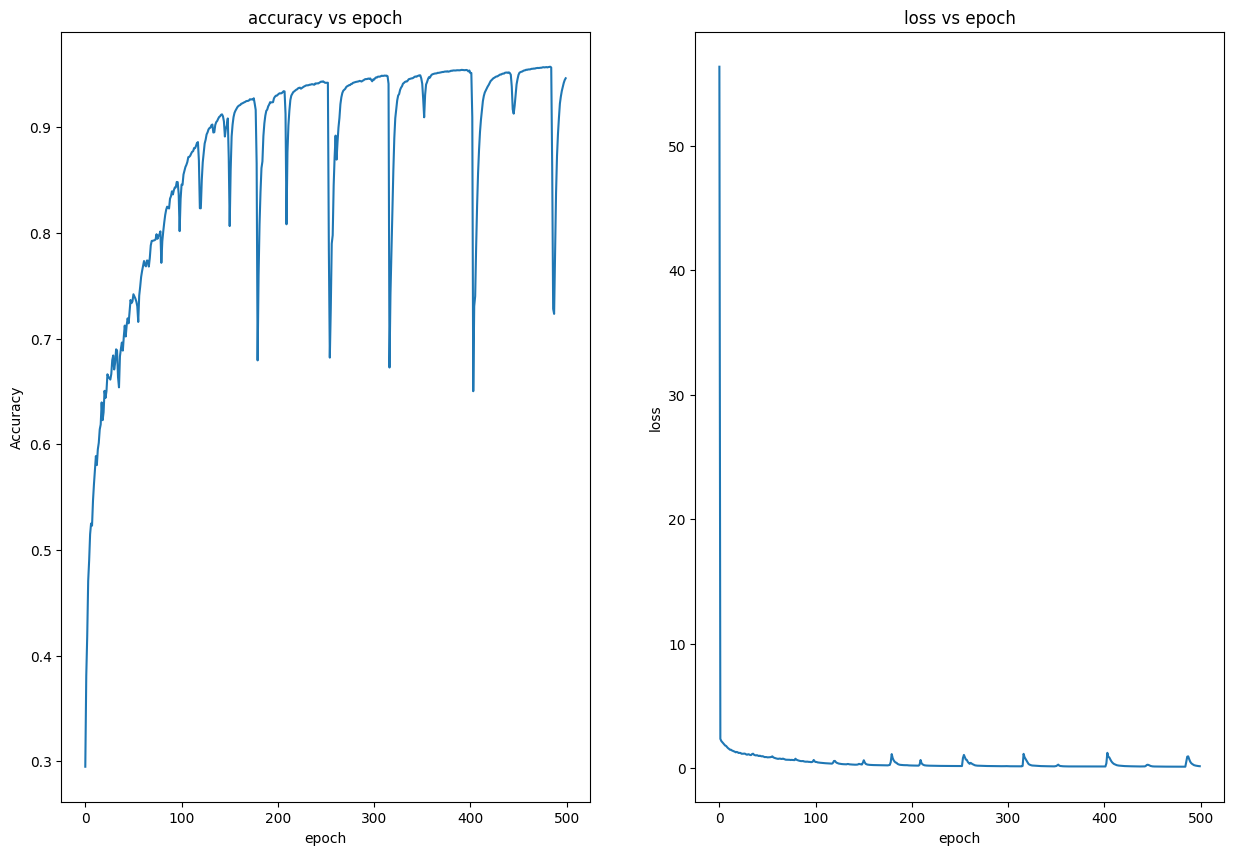

In [ ]:
fig ,ax  = plt.subplots(1,2,figsize=(15,10))
ax[0].plot(model_history.history['accuracy'])
ax[0].set_title('accuracy vs epoch')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Accuracy")
ax[1].plot(model_history.history['loss'])
ax[1].set_title('loss vs epoch')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
plt.show()

In [ ]:
def load_model(model_name):
  model_path = f"{working_directory}/{model_name}"
  model = tf.keras.models.load_model(model_path)
  return model



In [ ]:
model_name = f"{final_h}_{final_w}_{Unet_model.count_params()}"
Unet_model.save(f"{working_directory}/{model_name}")

In [ ]:
model = load_model(model_name)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    # else:
    #     display([sample_image, sample_mask,
    #          create_mask(Unet_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
print("training_dataset results:\n")
show_predictions(final_train_dataset, 6)
print("test_dataset results:\n")
show_predictions(final_test_dataset, 6)

In [ ]:
# model evaluation
print("Unet Model Evaluation: ")
model.evaluate(final_test_dataset)

Unet Model Evaluation: 
4/4 [==============================] - 1s 273ms/step - loss: 0.5741 - accuracy: 0.8641


[0.5740513801574707, 0.864147424697876]